In [1]:
import pandas as pd

In [2]:
# Structural Possession Prototype Framework with Descriptor Chains and LLM Dependency Draft

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def extract_soft_dependency_tree(text, model_name="bert-base-cased", layer_range=(4, 9)):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attentions = outputs.attentions
    start, end = layer_range
    avg_attention = torch.stack(attentions[start:end]).mean(dim=0)[0].mean(dim=0).numpy()

    G = nx.Graph()
    G.add_nodes_from(tokens)

    for i, token in enumerate(tokens):
        if token in ['[CLS]', '[SEP]']:
            continue
        top_indices = np.argsort(avg_attention[i])[-3:]
        for j in top_indices:
            source = tokens[j]
            if source not in ['[CLS]', '[SEP]']:
                weight = float(avg_attention[i][j])
                G.add_edge(token, source, weight=weight)

    # Build spanning tree using maximum attention
    T = nx.maximum_spanning_tree(G, weight='weight')
    return tokens, T

# Visualize dependency as graph with role labels and weights

def visualize_soft_dependencies(text, model_name="bert-base-cased", layer_range=(4, 9), top_k=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attentions = outputs.attentions
    start, end = layer_range
    avg_attention = torch.stack(attentions[start:end]).mean(dim=0)[0].mean(dim=0).numpy()

    G = nx.Graph()
    G.add_nodes_from(tokens)

    for i, token in enumerate(tokens):
        if token in ['[CLS]', '[SEP]']:
            continue
        top_indices = np.argsort(avg_attention[i])[-top_k:]
        for j in top_indices:
            source = tokens[j]
            if source not in ['[CLS]', '[SEP]']:
                label = f"({source}, {token})"
                weight = round(float(avg_attention[i][j]), 3)
                G.add_edge(source, token, label=label, weight=weight)

    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'label')
    weights = [G[u][v]['weight'] * 5 for u,v in G.edges()]

    plt.figure(figsize=(12, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=weights, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkgreen')
    plt.title(f"Typed Soft Dependency Graph for: '{text}'")
    plt.show()




In [3]:
def visualize_per_layer(text, model_name="bert-base-cased", layer_range=(4, 9), top_k=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attentions = outputs.attentions
    start, end = layer_range
    Gs = []
    for layer in range(start, end):
        attn = attentions[layer][0].mean(dim=0).numpy()
        G = nx.Graph()
        G.add_nodes_from(tokens)

        for i, token in enumerate(tokens):
            if token in ['[CLS]', '[SEP]']:
                continue
            top_indices = np.argsort(attn[i])[-top_k:]
            for j in top_indices:
                source = tokens[j]
                if source not in ['[CLS]', '[SEP]']:
                    label = f"({source}, {token})"
                    weight = round(float(attn[i][j]), 3)
                    G.add_edge(source, token, label=label, weight=weight)

        # pos = nx.spring_layout(G, seed=42)
        # edge_labels = nx.get_edge_attributes(G, 'label')
        # weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]

        # plt.figure(figsize=(12, 7))
        # nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=weights, font_weight='bold')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkgreen')
        # plt.title(f"Layer {layer}: Soft Dependency Graph")
        # plt.show()
        Gs.append(G)
    return Gs

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the function to analyze subword fragmentation
def analyze_subword_fragmentation(text, model_name="bert-base-cased", layer=-1, top_k=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, output_attentions=True)
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    attentions = outputs.attentions[layer][0].mean(dim=0).numpy()

    G = nx.Graph()
    G.add_nodes_from(tokens)

    # Build the attention-based graph
    for i, token in enumerate(tokens):
        if token in ['[CLS]', '[SEP]']:
            continue
        top_indices = np.argsort(attentions[i])[-top_k:]
        for j in top_indices:
            source = tokens[j]
            if source not in ['[CLS]', '[SEP]']:
                weight = float(attentions[i][j])
                G.add_edge(source, token, weight=weight)

    # Group subwords into words
    words = []
    current_word = ""
    word_map = []
    for i, token in enumerate(tokens):
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                words.append(current_word)
            current_word = token
        word_map.append((current_word, token))
    if current_word:
        words.append(current_word)

    # Track token locations in the graph
    word_to_tokens = defaultdict(list)
    for word, token in word_map:
        word_to_tokens[word].append(token)

    # Detect fragmented words
    fragmented_words = {}
    for word, sub_tokens in word_to_tokens.items():
        subgraph = G.subgraph(sub_tokens)
        components = list(nx.connected_components(subgraph))
        if len(components) > 1:
            fragmented_words[word] = components

    return fragmented_words

In [8]:
def show_graph(G, title="", edge_labels=False):
        pos = nx.spring_layout(G, seed=42)
        edge_labels = nx.get_edge_attributes(G, 'label')
        weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
        plt.figure(figsize=(12, 7))
        nx.draw(G, pos, with_labels=True, node_color=[(0.2,0.2,0.8,0.01)], edge_color='lightblue', width=1, font_weight='bold')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkgreen')
        plt.title(title)
        plt.show()

def show_layers(G):
    for i, g in enumerate(G,1):
        show_graph(g, f"layer {i}") 
    show_graph(combine_graphs_weighted(G), "All layers combined")

In [13]:
G=visualize_per_layer("The man who ate the large dinner finds a bike near the lake",model_name="NbAiLab/nb-bert-base")


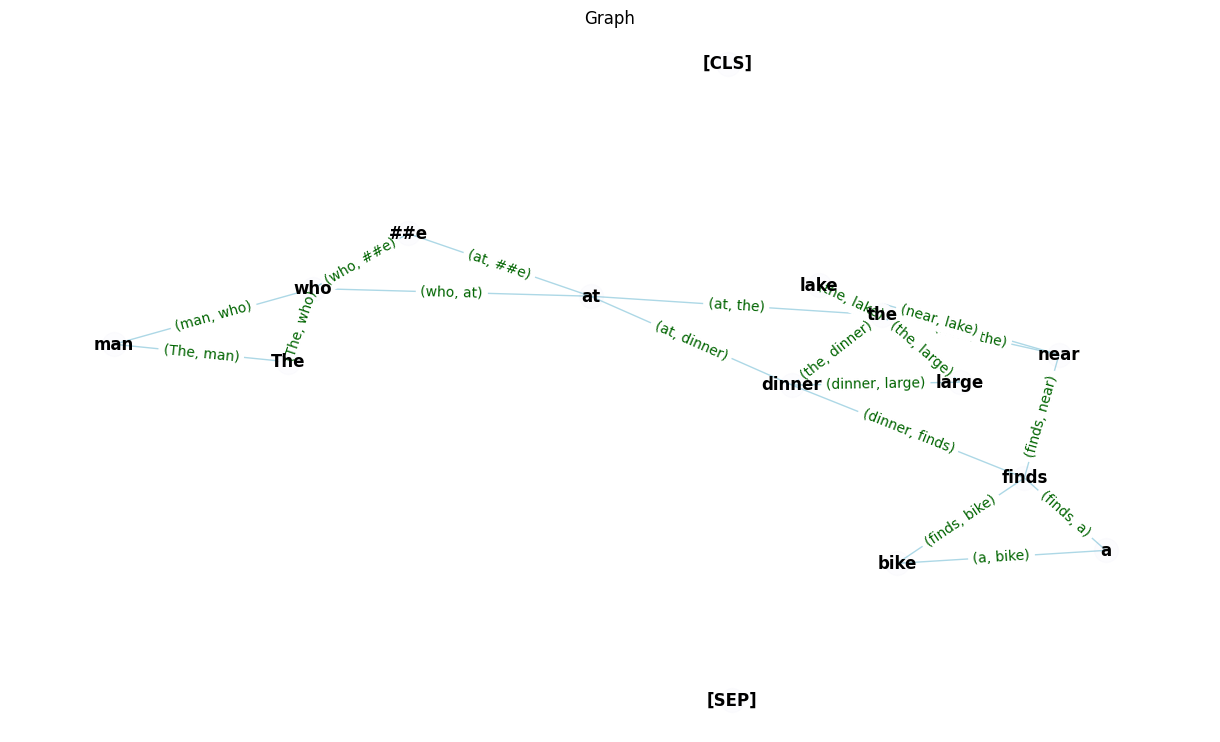

In [14]:
G[0].remove_edges_from(nx.selfloop_edges(G[0]))
show_graph(G[0],"Graph", edge_labels=True)

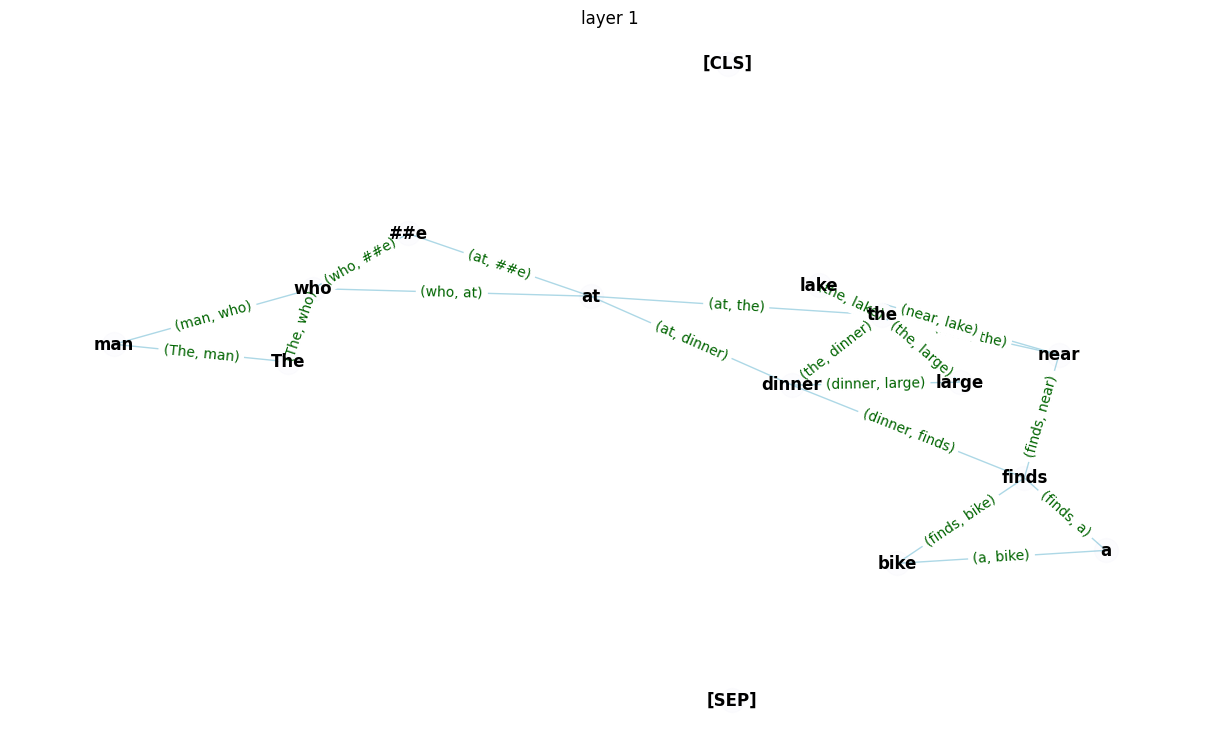

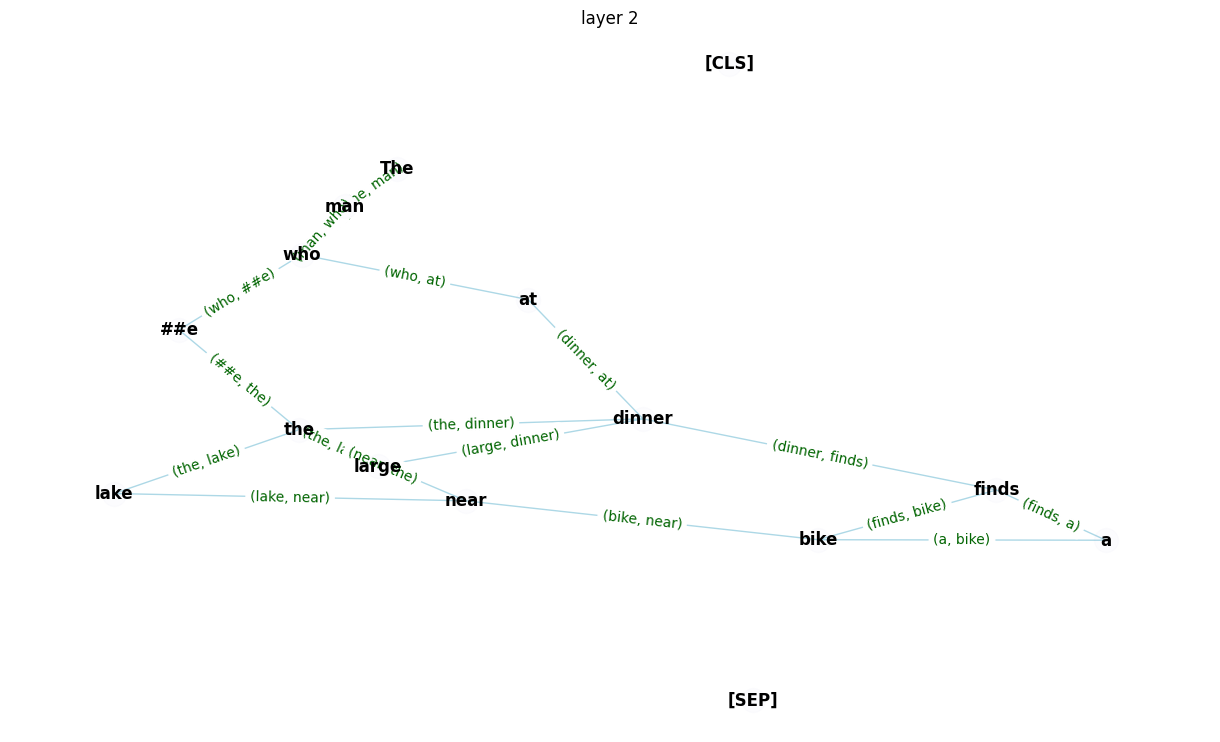

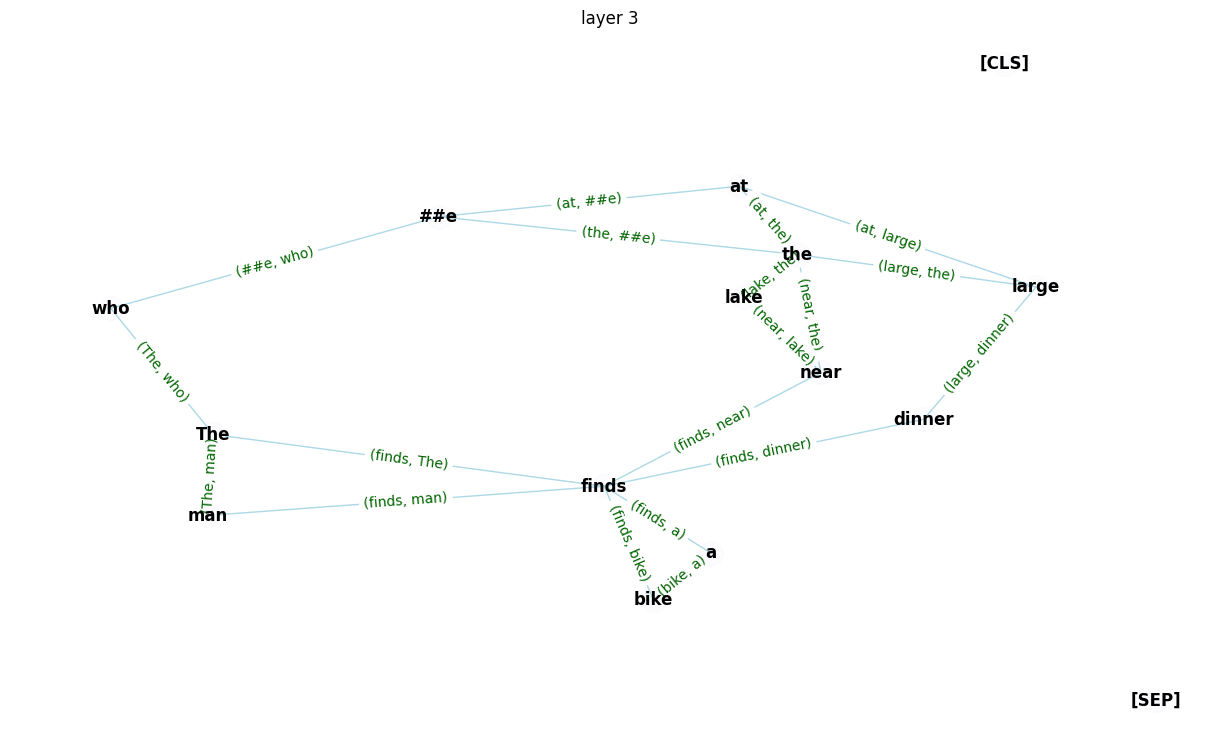

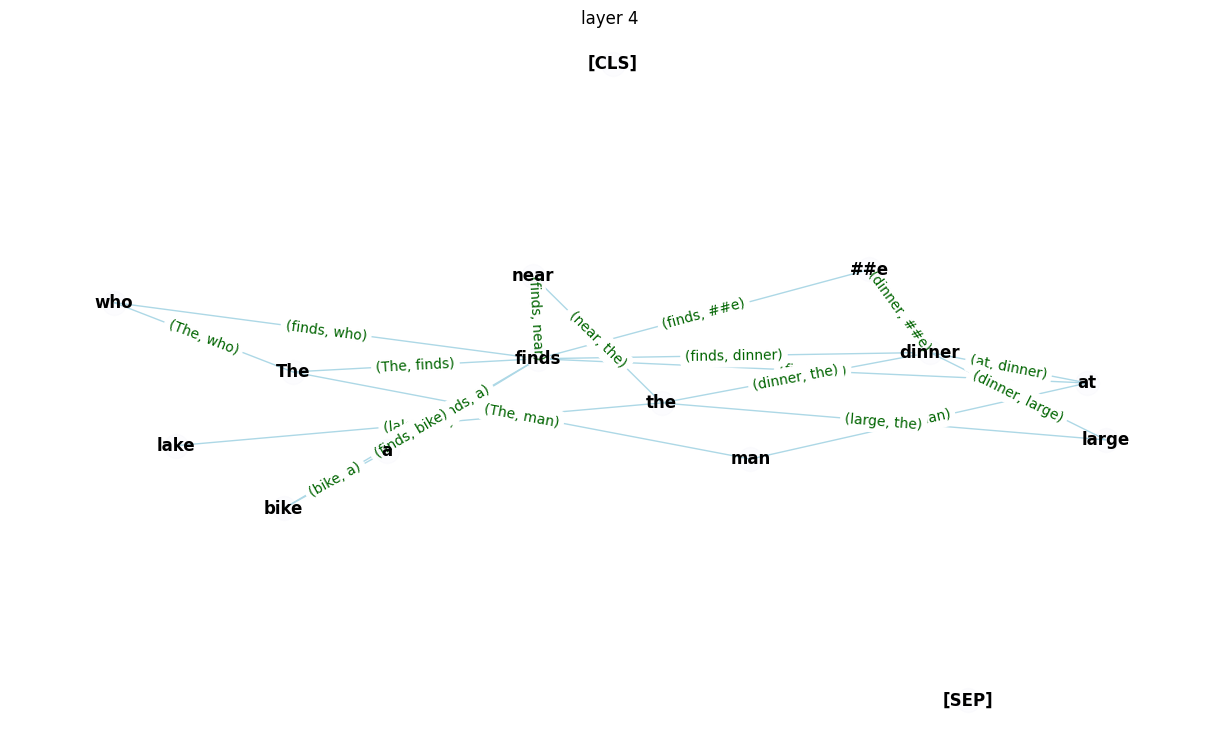

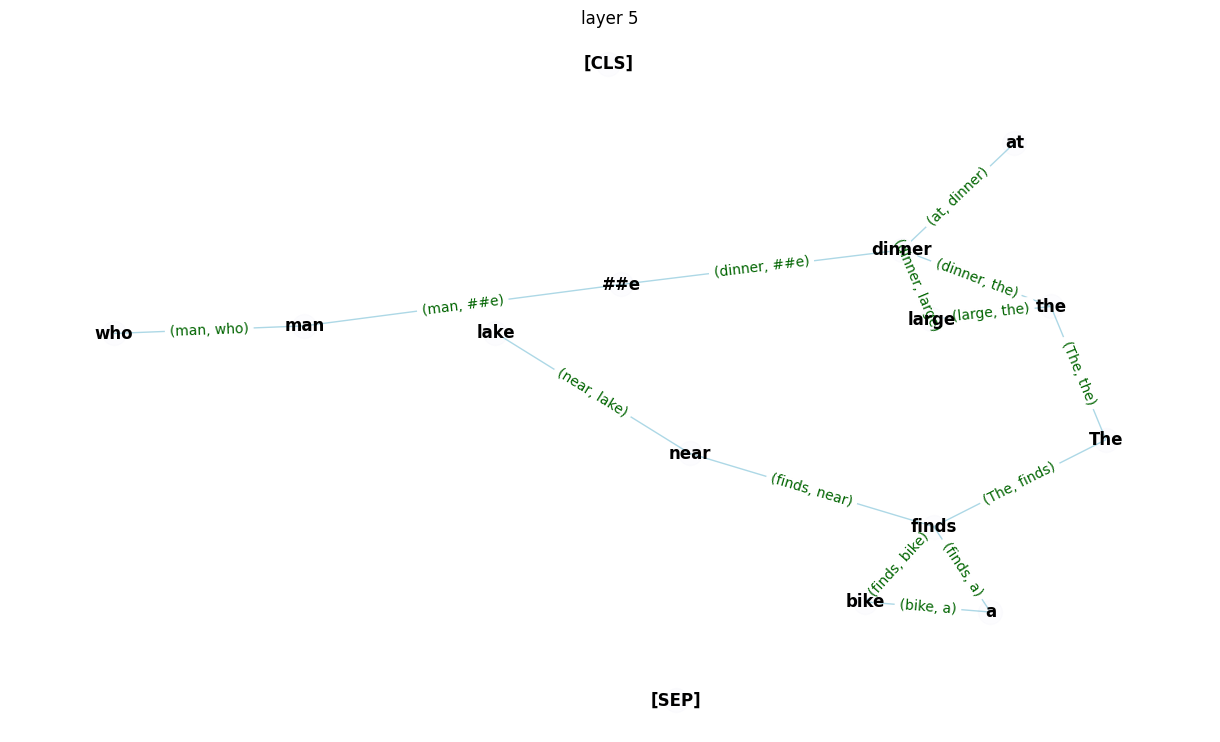

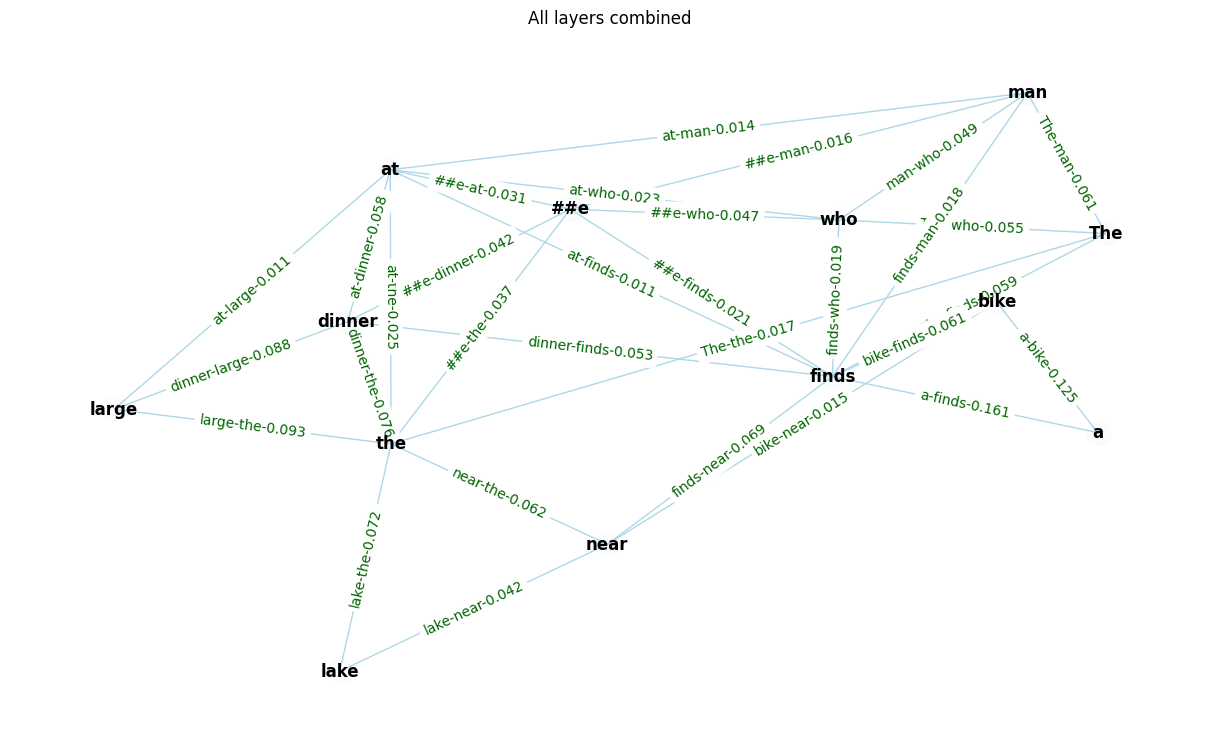

In [15]:
for i, g in enumerate(G,1):
    g.remove_edges_from(nx.selfloop_edges(g))
    show_graph(g, f"layer {i}") 
show_graph(combine_graphs_weighted(G), "All layers combined")

In [16]:
import networkx as nx
from collections import defaultdict

def combine_graphs_weighted(layers):
    combined_weights = defaultdict(float)
    total_layers = len(layers)
    total_weight = sum(range(1, total_layers + 1))

    for i, G in enumerate(layers, 1):
        weight_factor = i / total_weight
        for u, v, d in G.edges(data=True):
            key = tuple(sorted((u, v)))
            combined_weights[key] += d['weight'] * weight_factor

    # Build the final graph
    combined_graph = nx.Graph()
    for (u, v), weight in combined_weights.items():
        combined_graph.add_edge(u, v, weight=round(weight, 3), label=f"{u}-{v}-{round(weight,3)}")

    return combined_graph





In [17]:
Gnb=visualize_per_layer("Jeg ville egentlig bare ta to glass, men så ble det alt for mange", model_name="NbAiLab/nb-bert-base")

In [18]:
G_at=visualize_per_layer("Hvem trodde du at ble syk", model_name="NbAiLab/nb-bert-base")

In [19]:
G_fi = visualize_per_layer("Du trodde at han ble syk", model_name="NbAiLab/nb-bert-base")

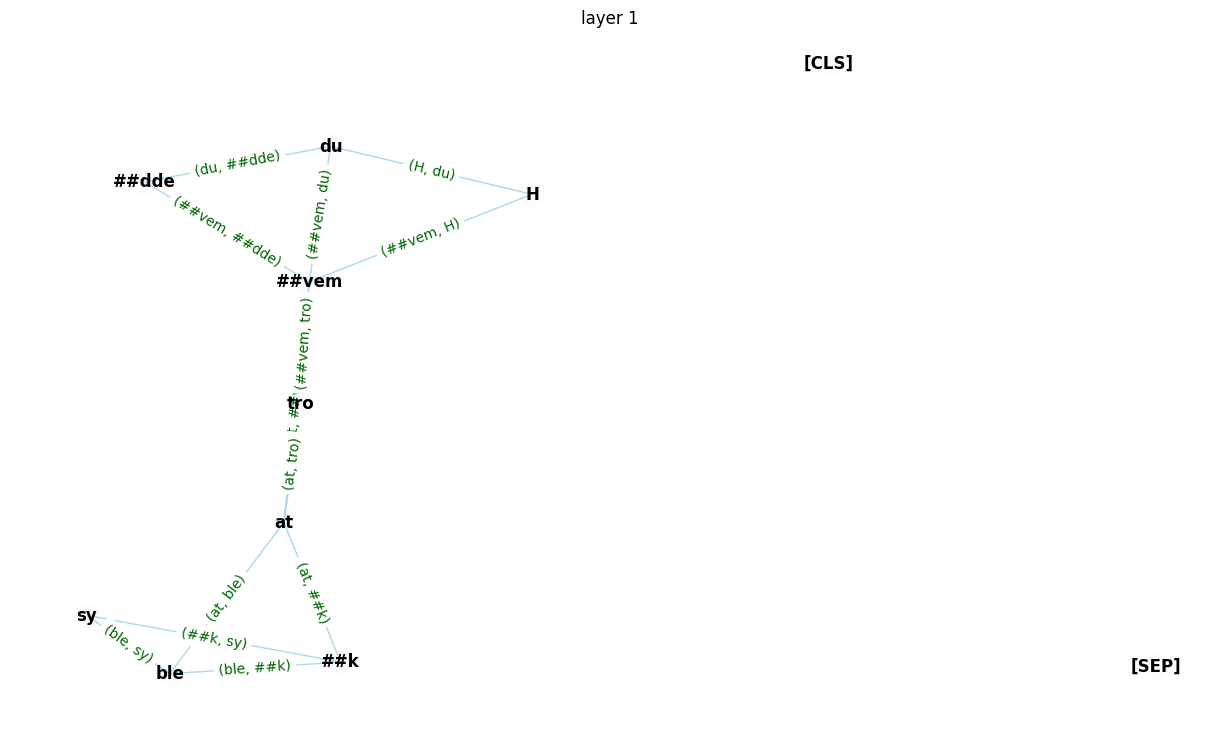

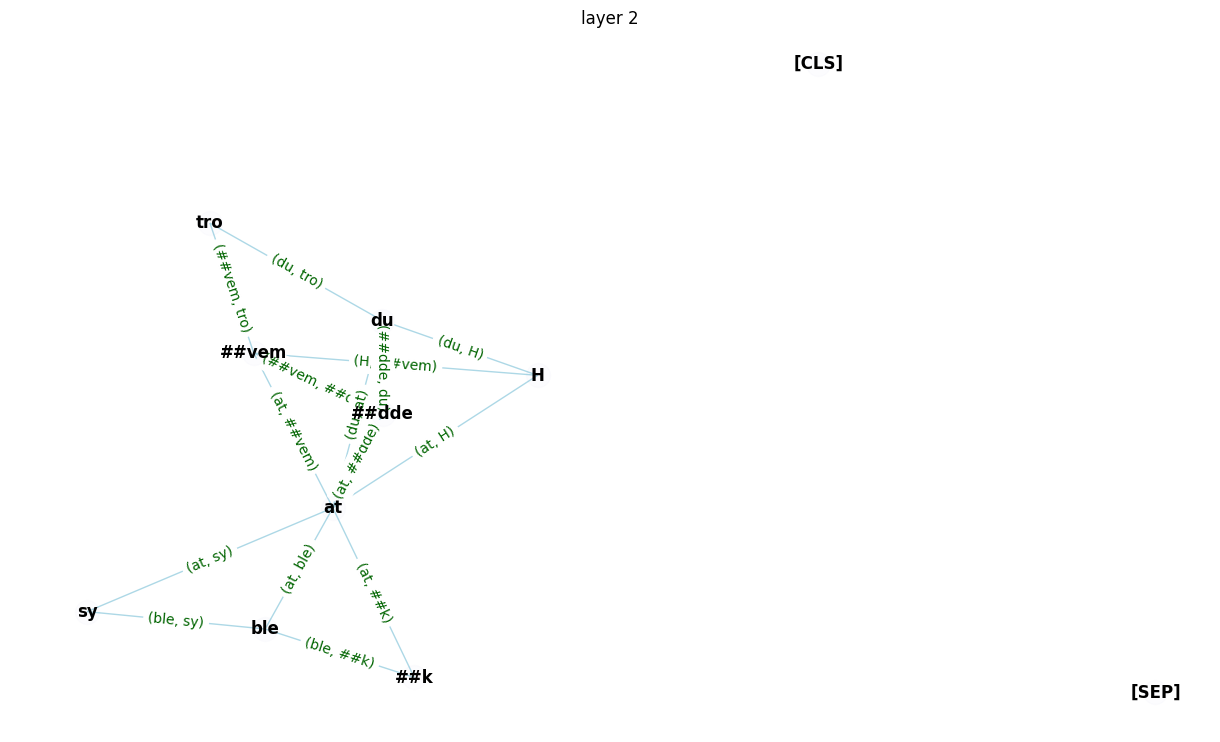

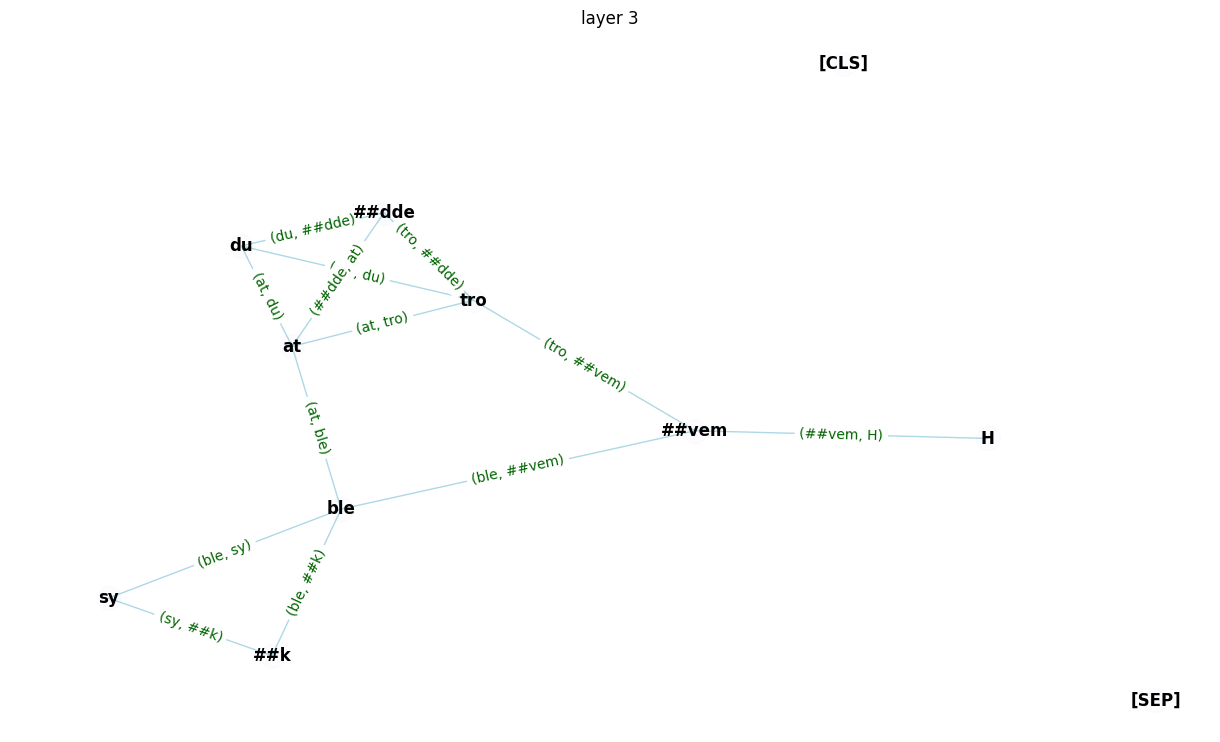

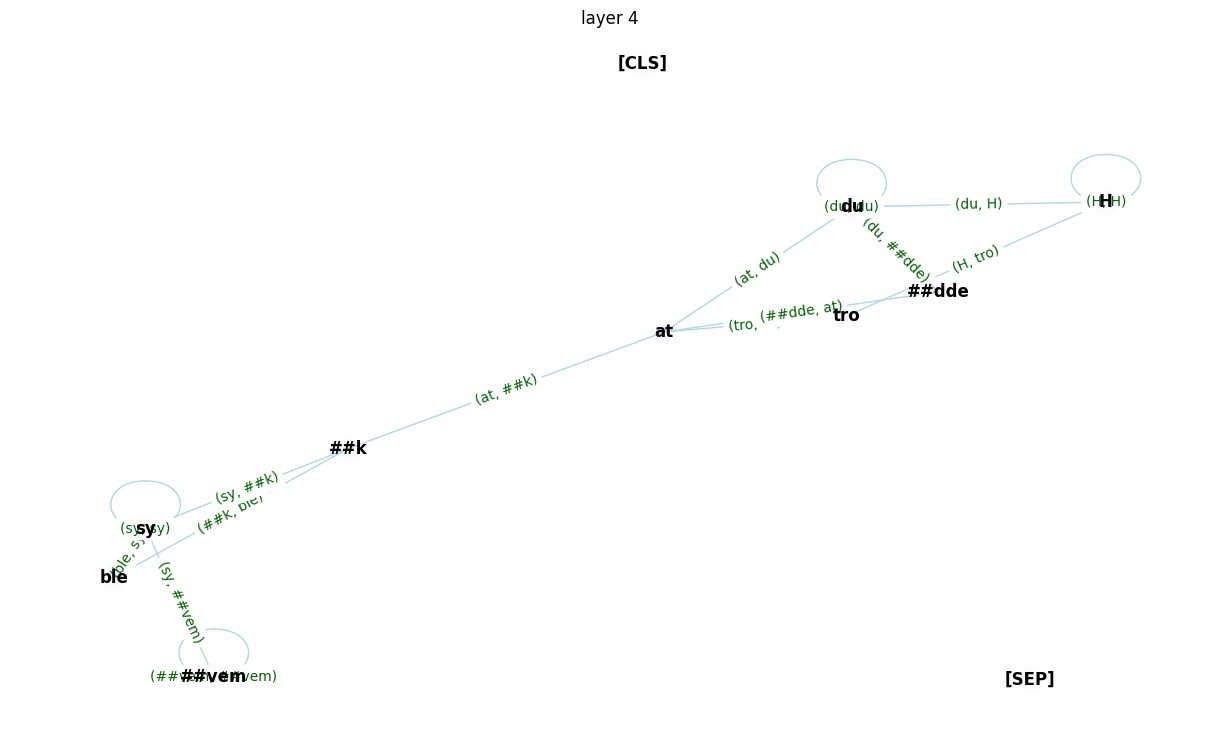

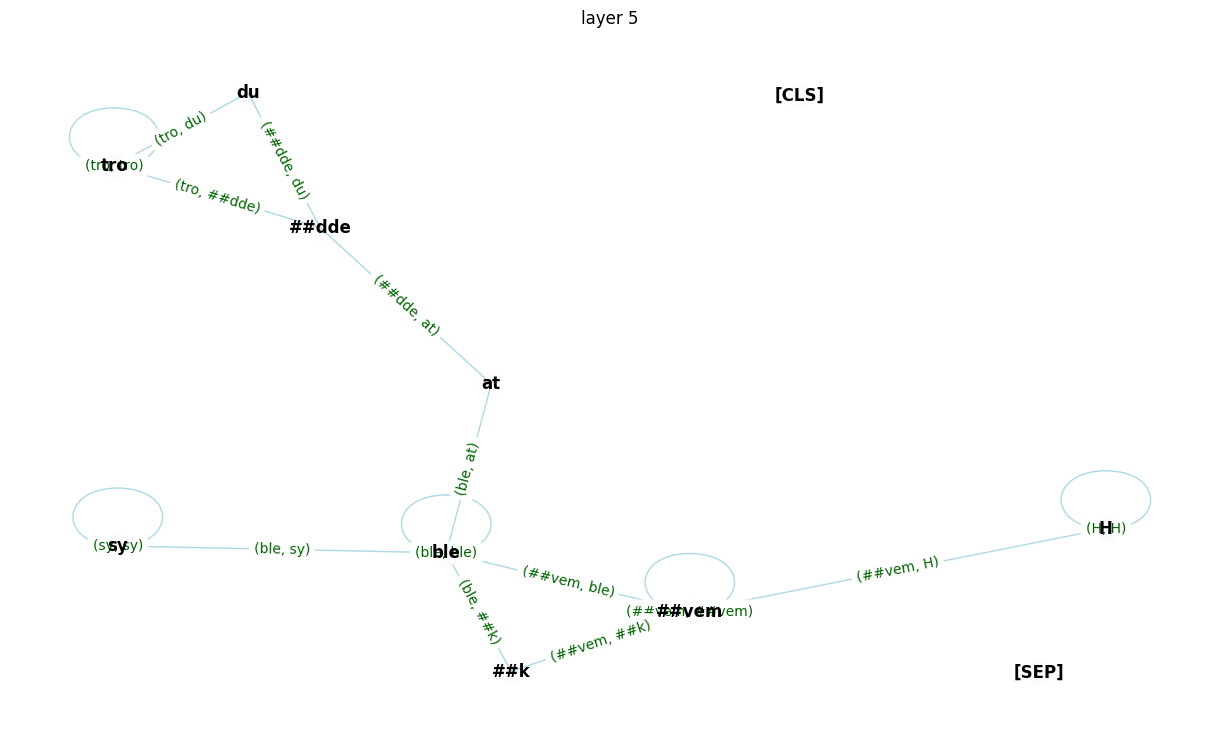

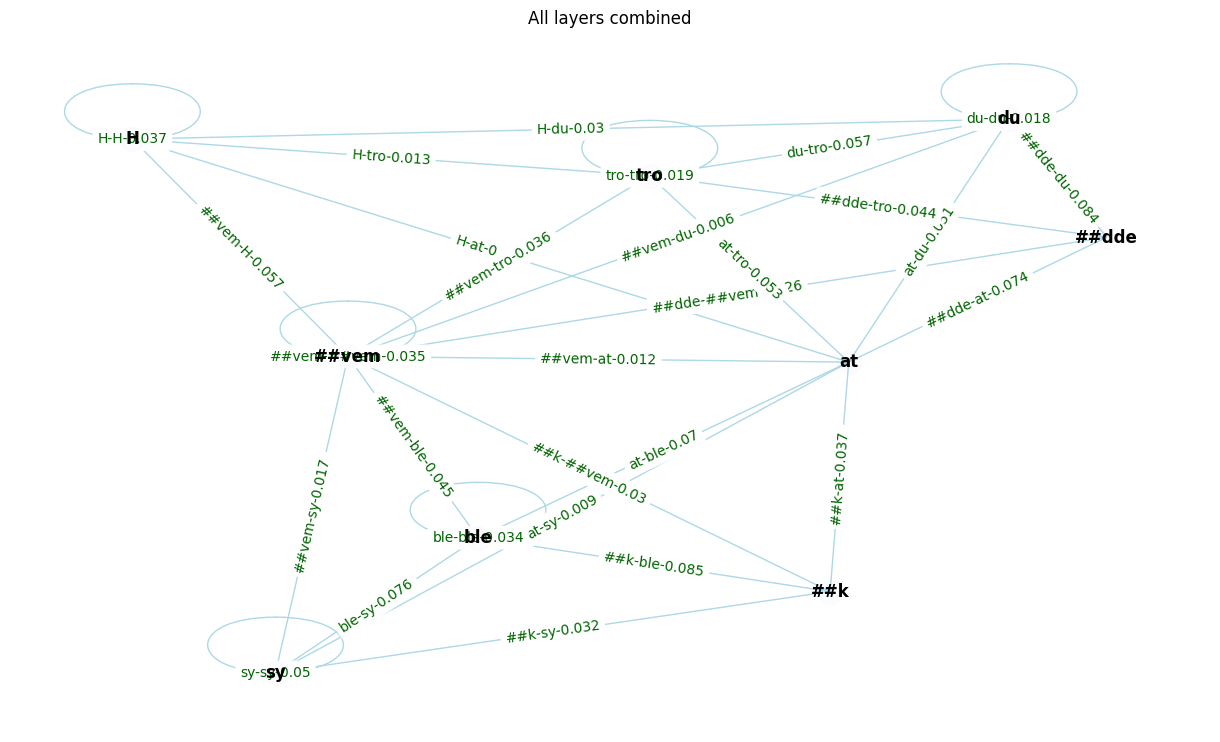

In [20]:
show_layers(G_at)

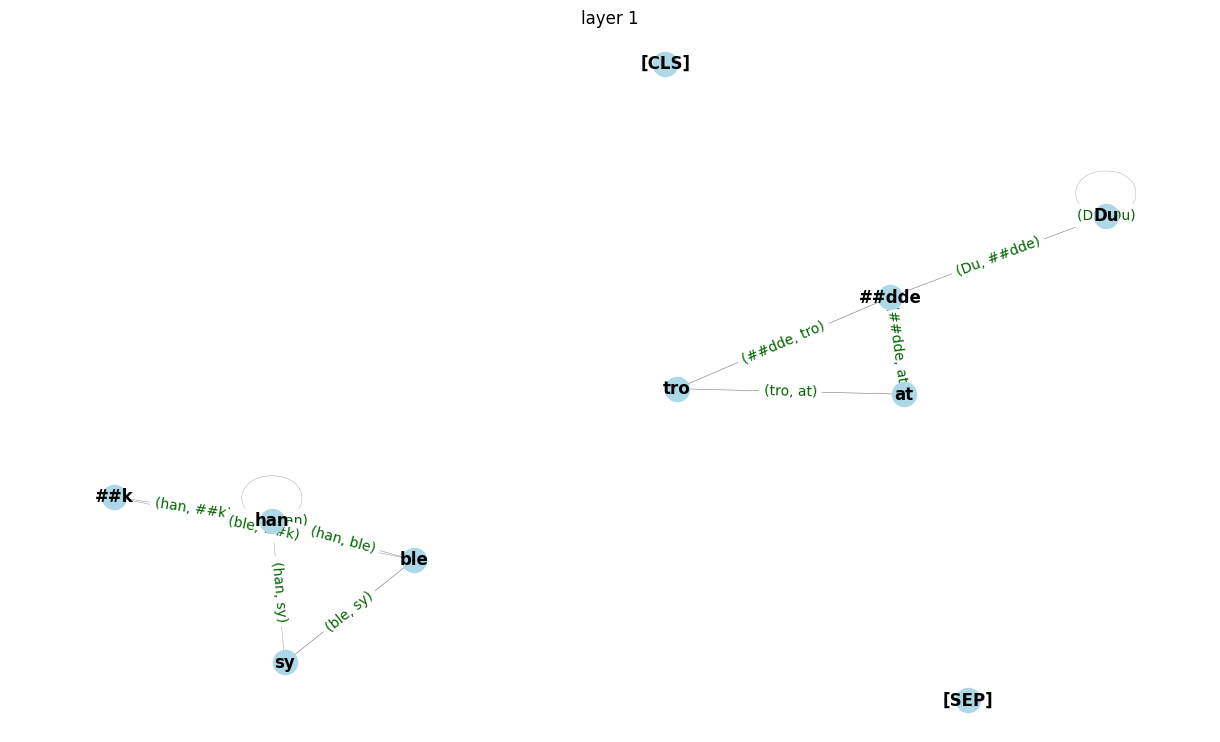

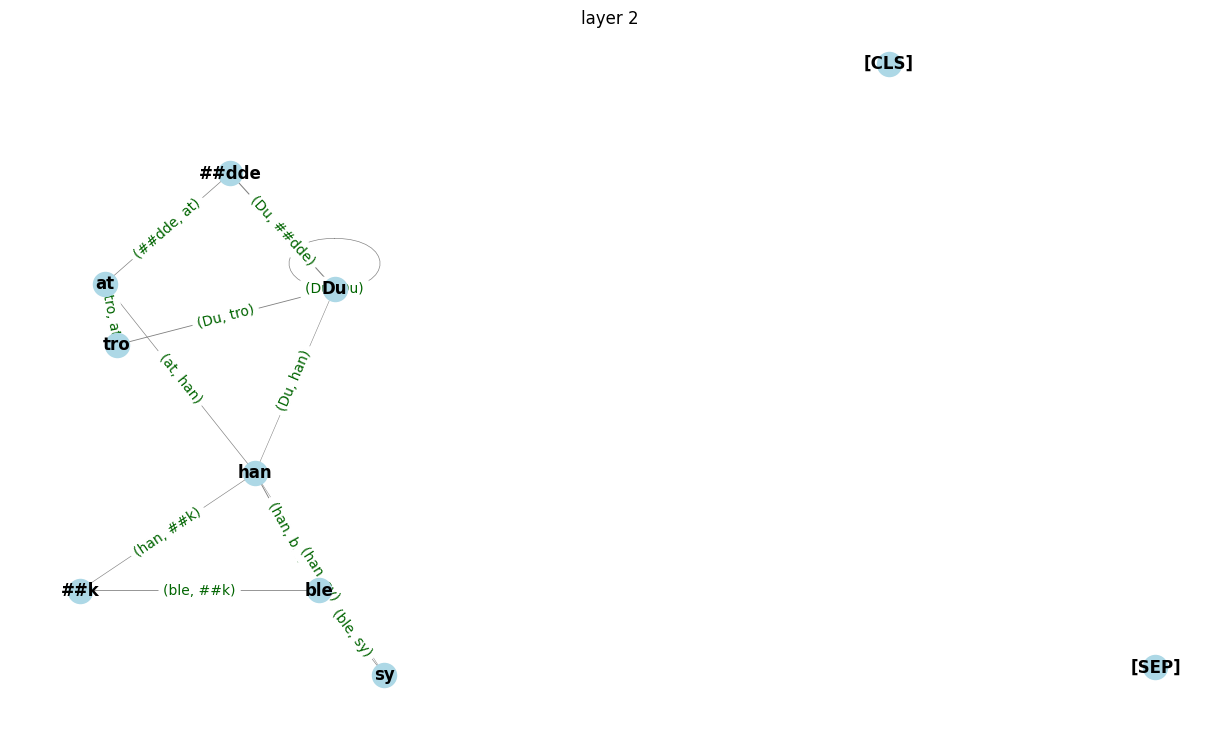

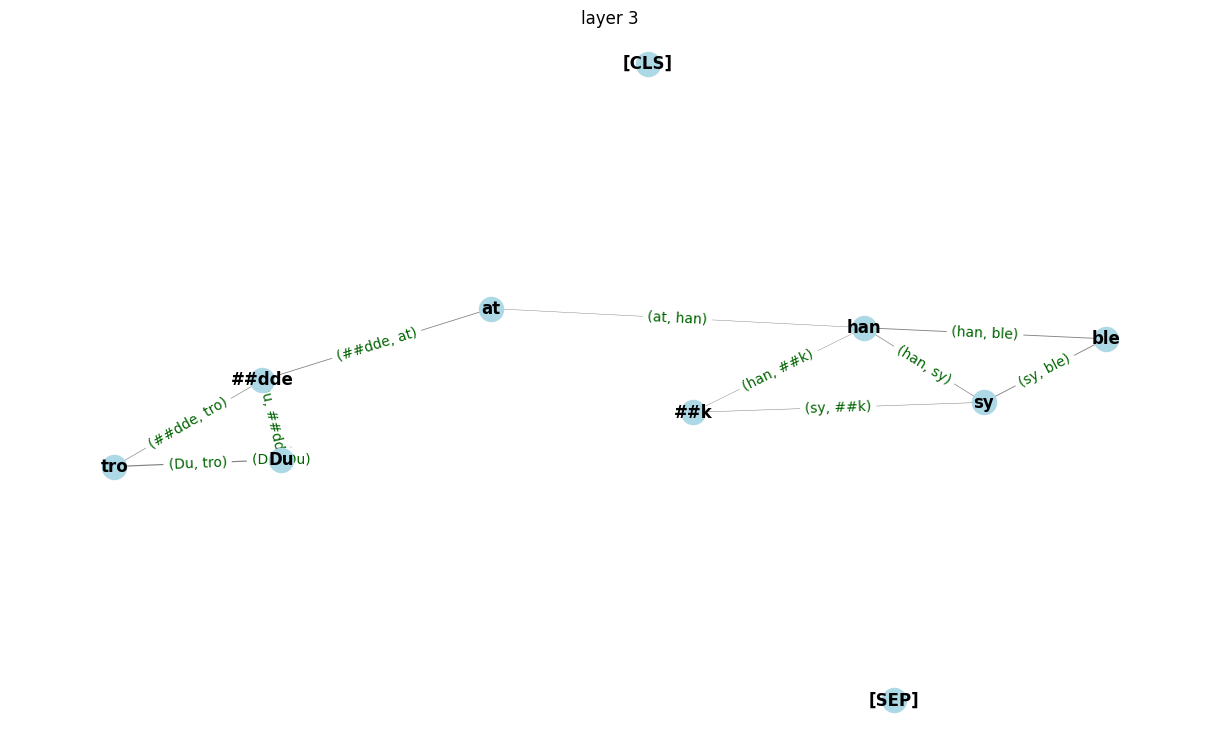

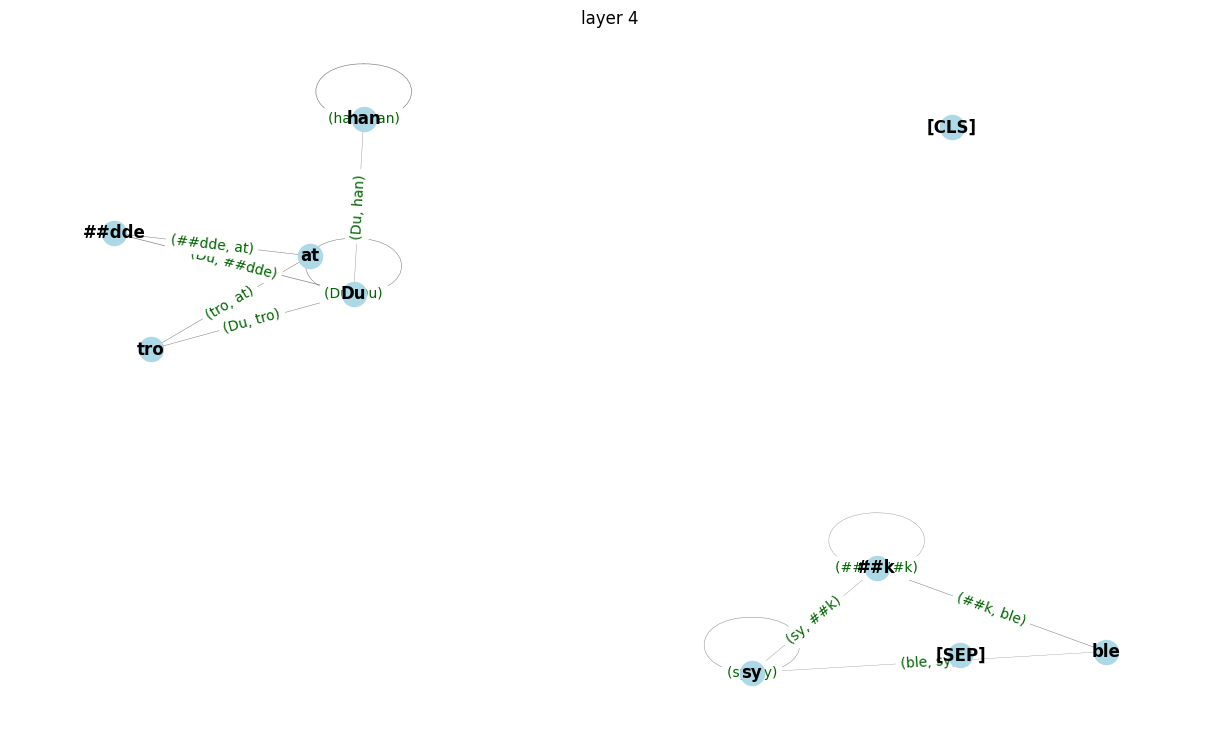

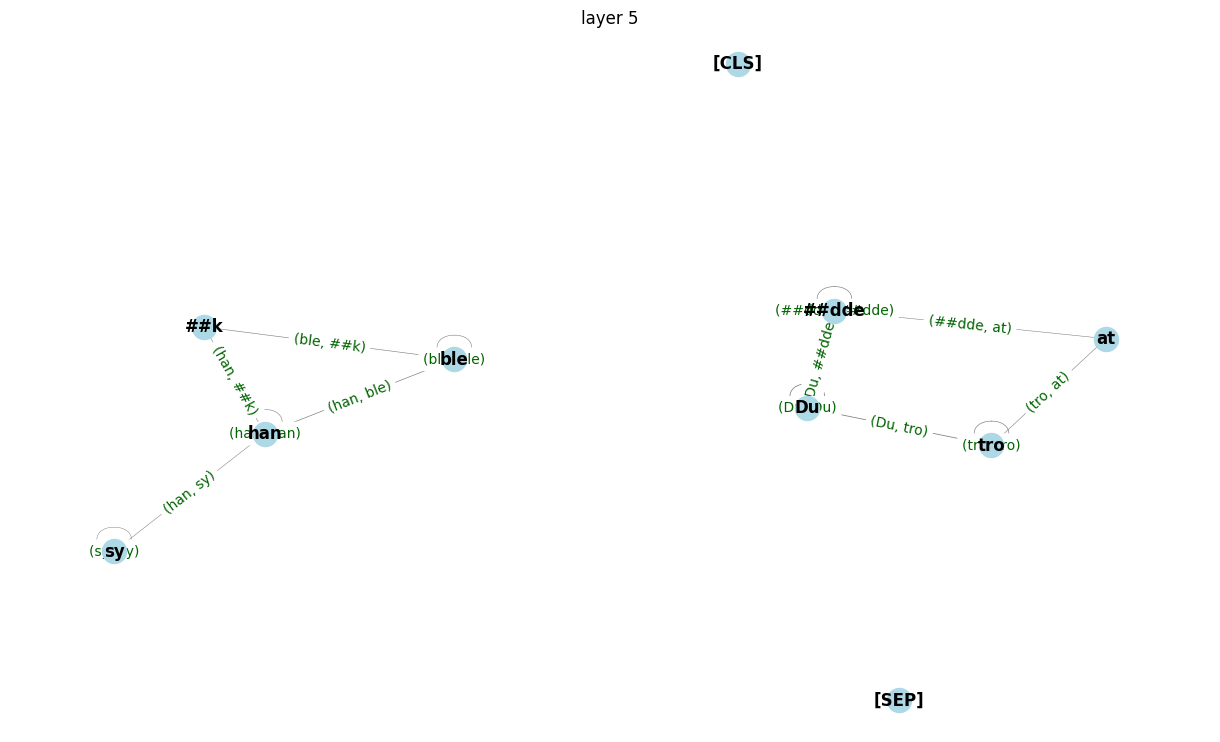

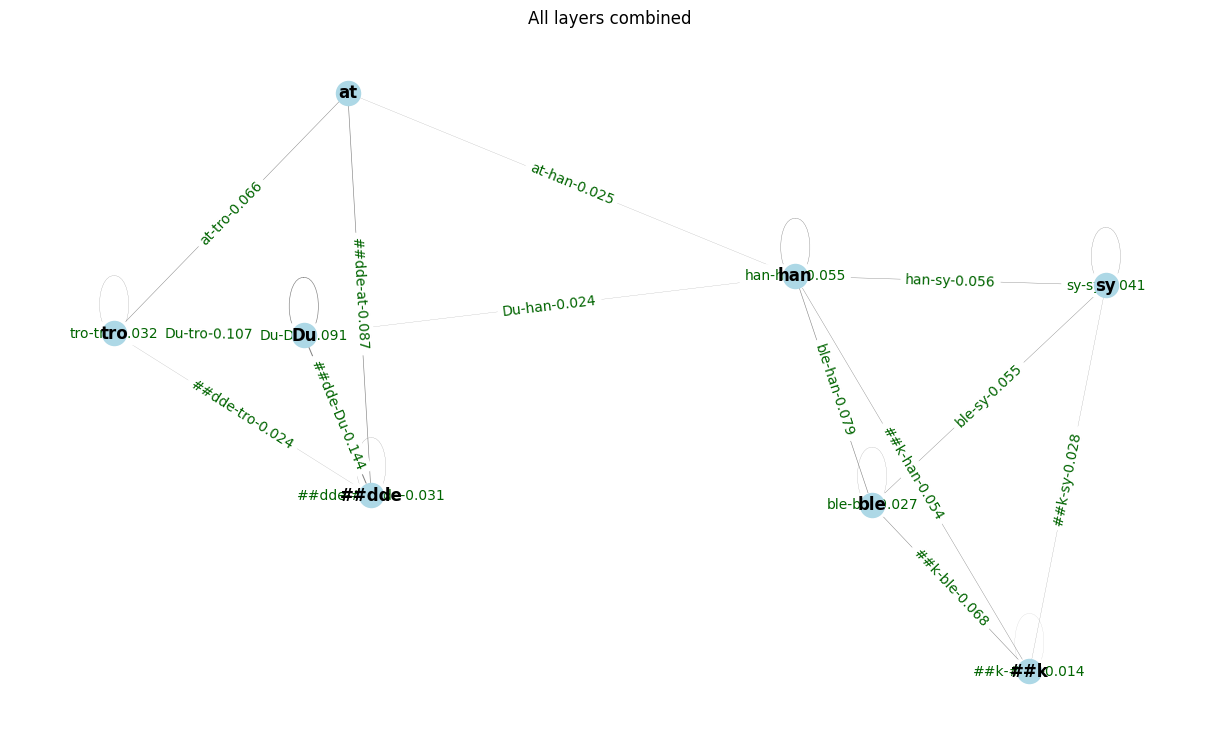

In [71]:
show_layers(G_fi)

In [66]:
G=visualize_per_layer("Jeg ville egentlig bare ta to glass, men så ble det alt for mange", model_name="bert-base-cased")

In [66]:
G=visualize_per_layer("Jeg ville egentlig bare ta to glass, men så ble det alt for mange", model_name="bert-base-cased")

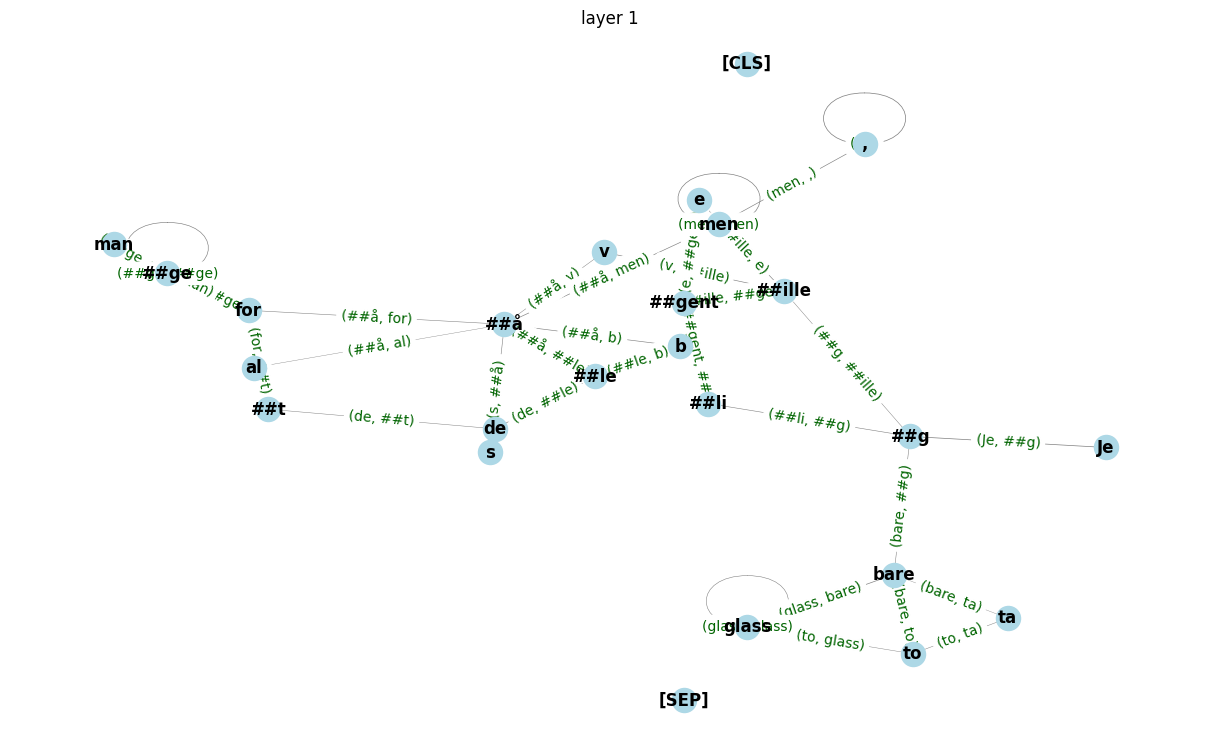

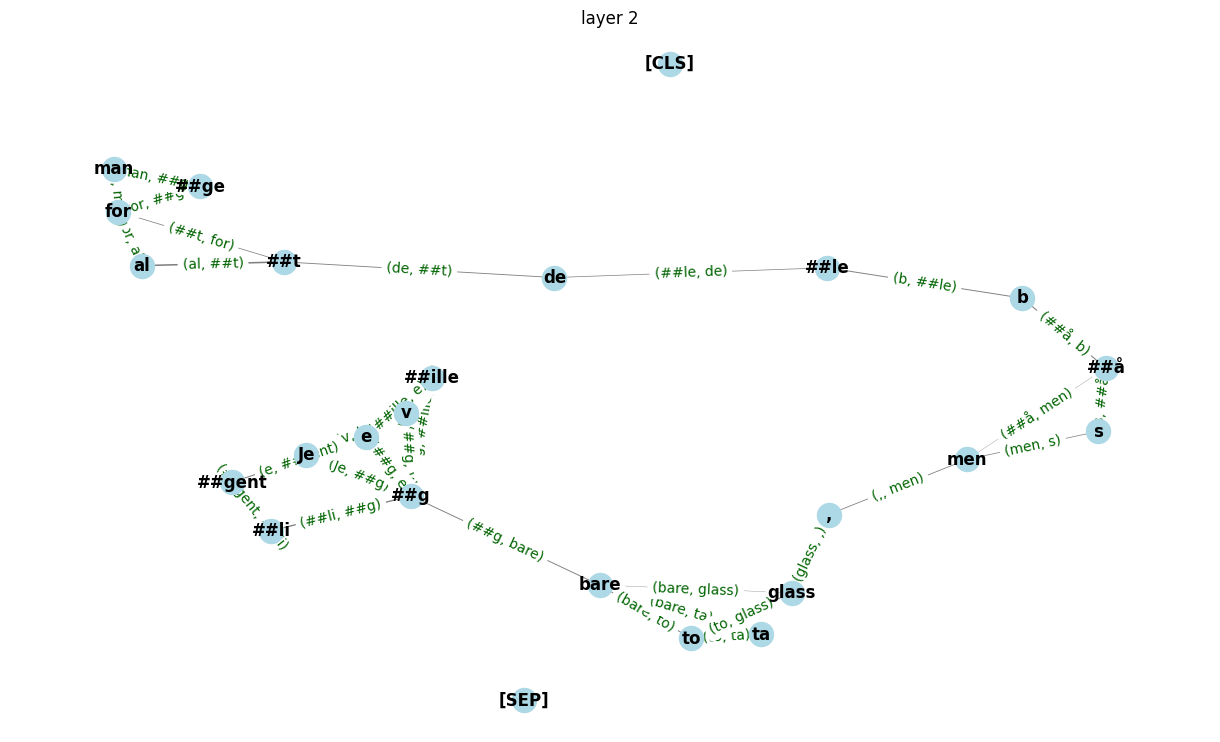

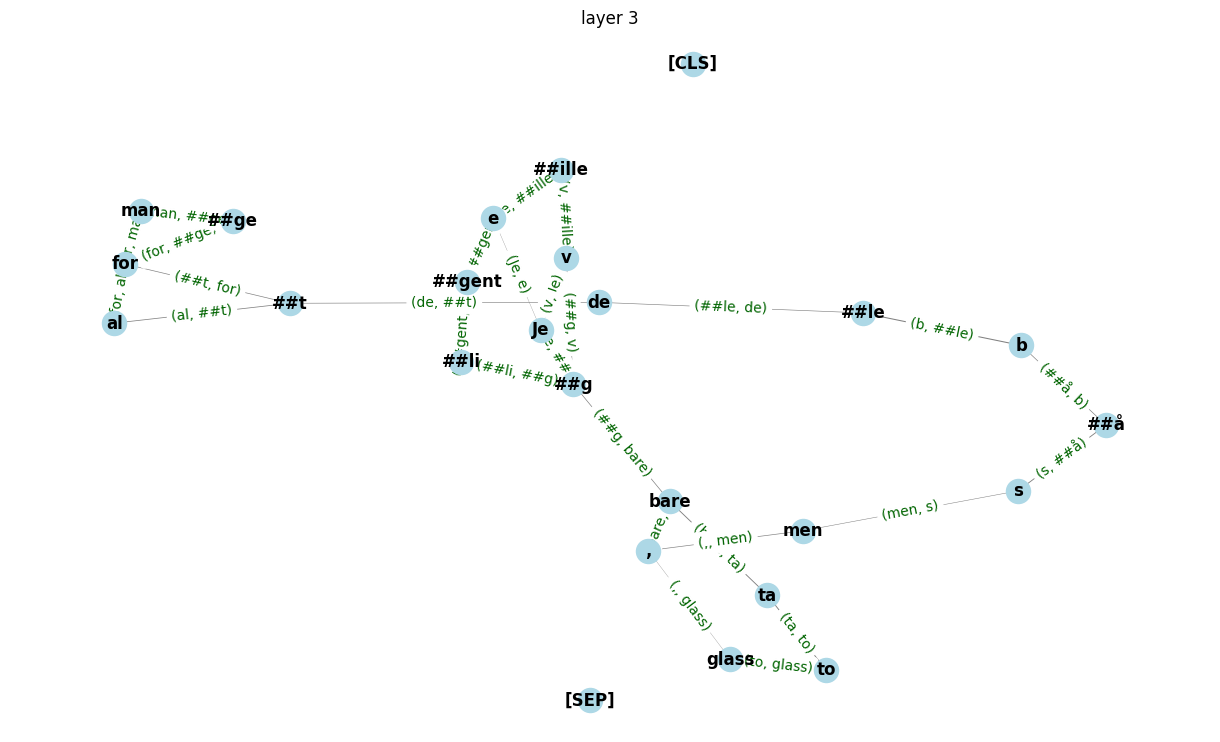

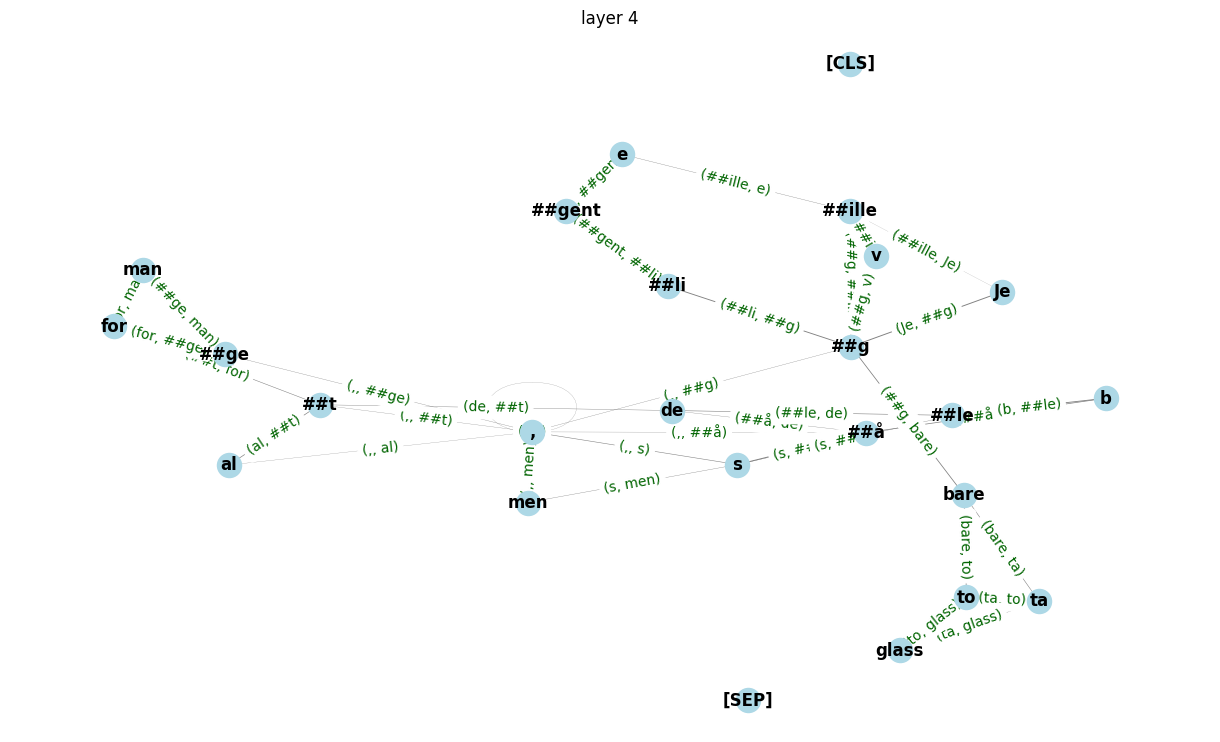

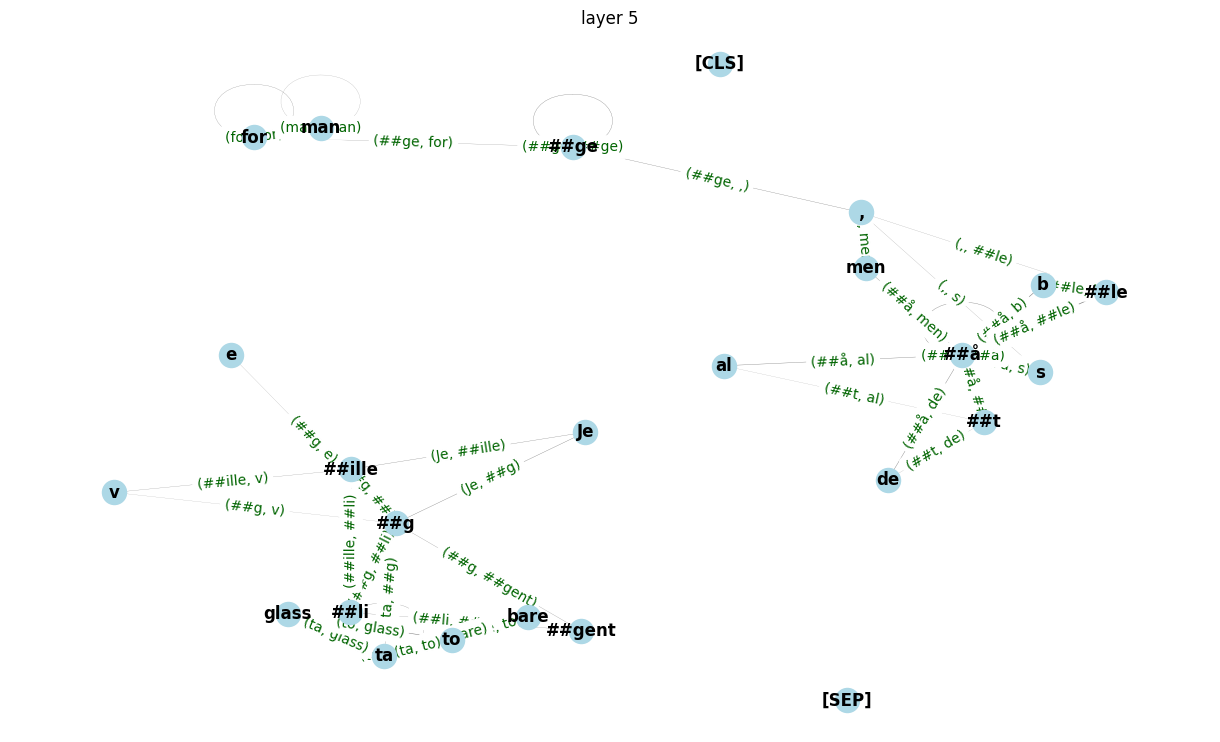

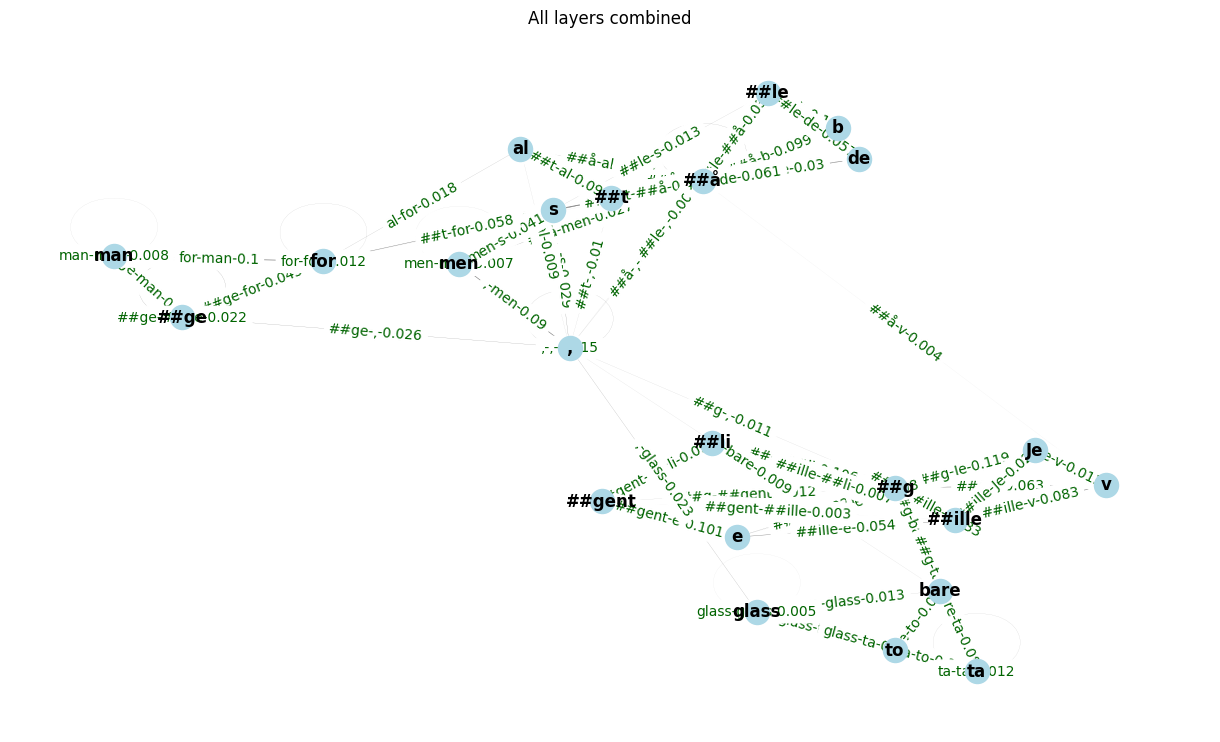

In [68]:
show_layers(G)

In [42]:
Gc = combine_graphs_weighted(G)

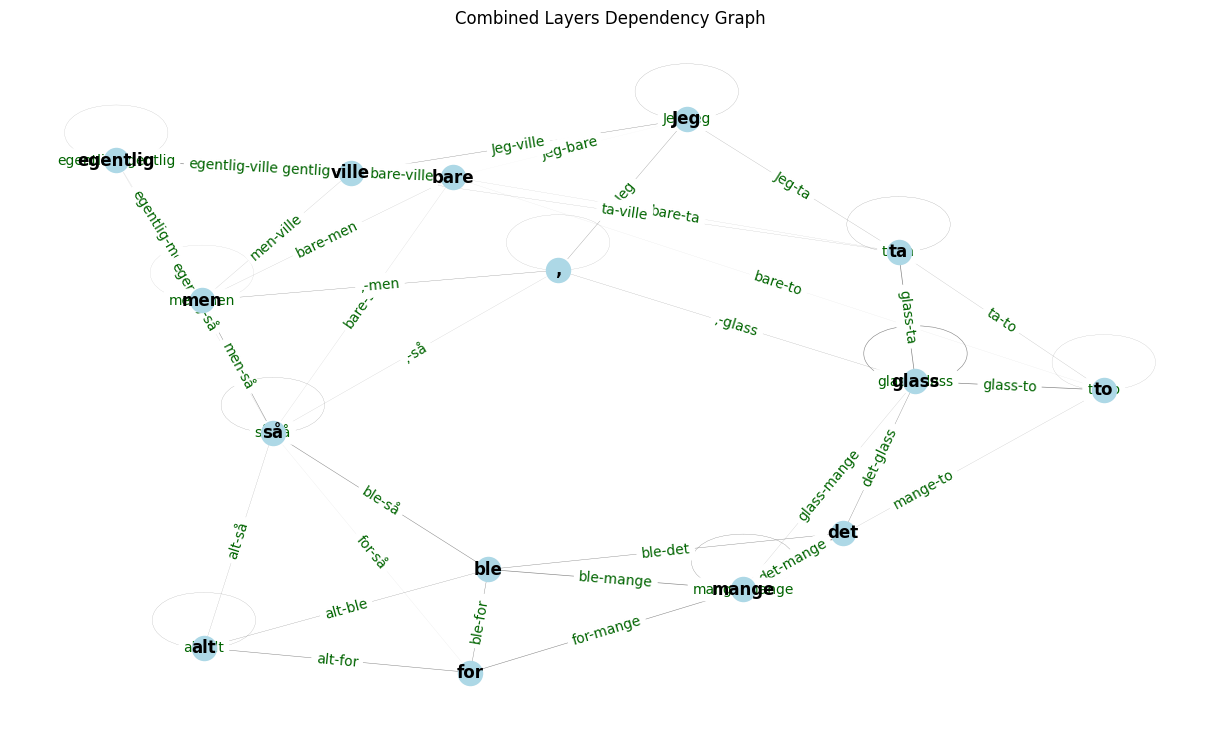

In [49]:
show_graph(Gc)

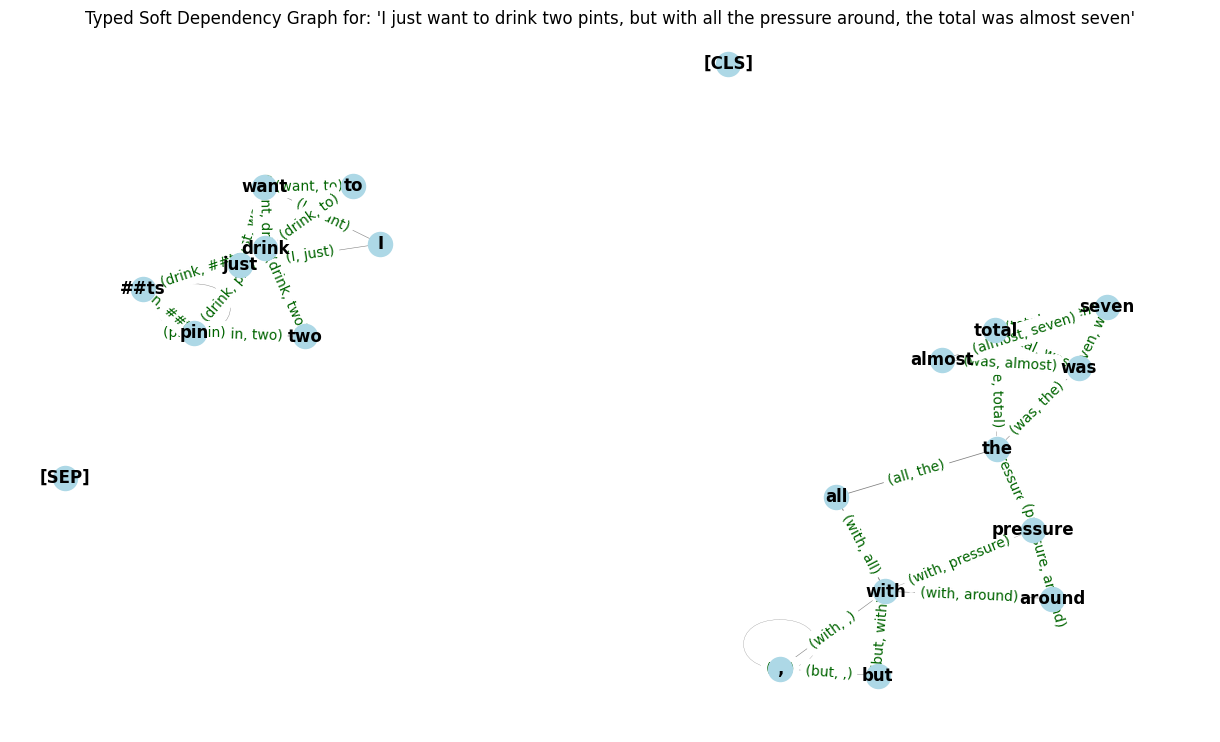

In [11]:
visualize_soft_dependencies("I just want to drink two pints, but with all the pressure around, the total was almost seven")

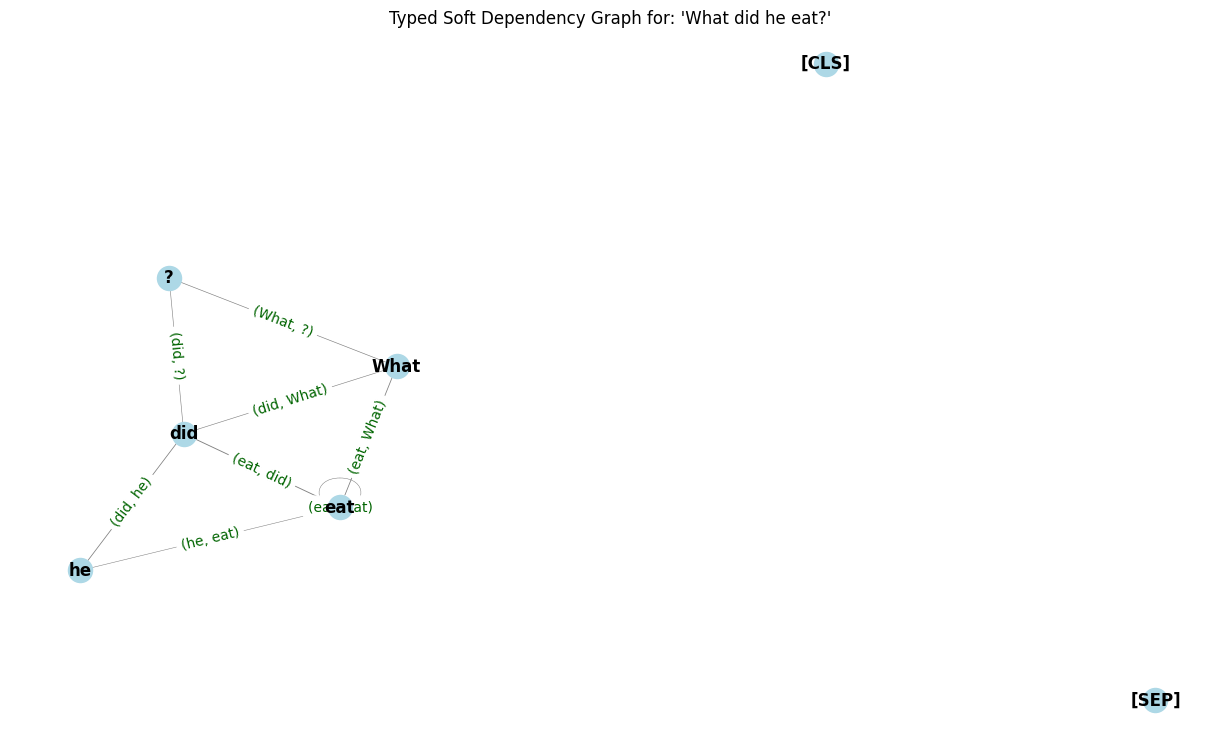

In [12]:
visualize_soft_dependencies("What did he eat?")

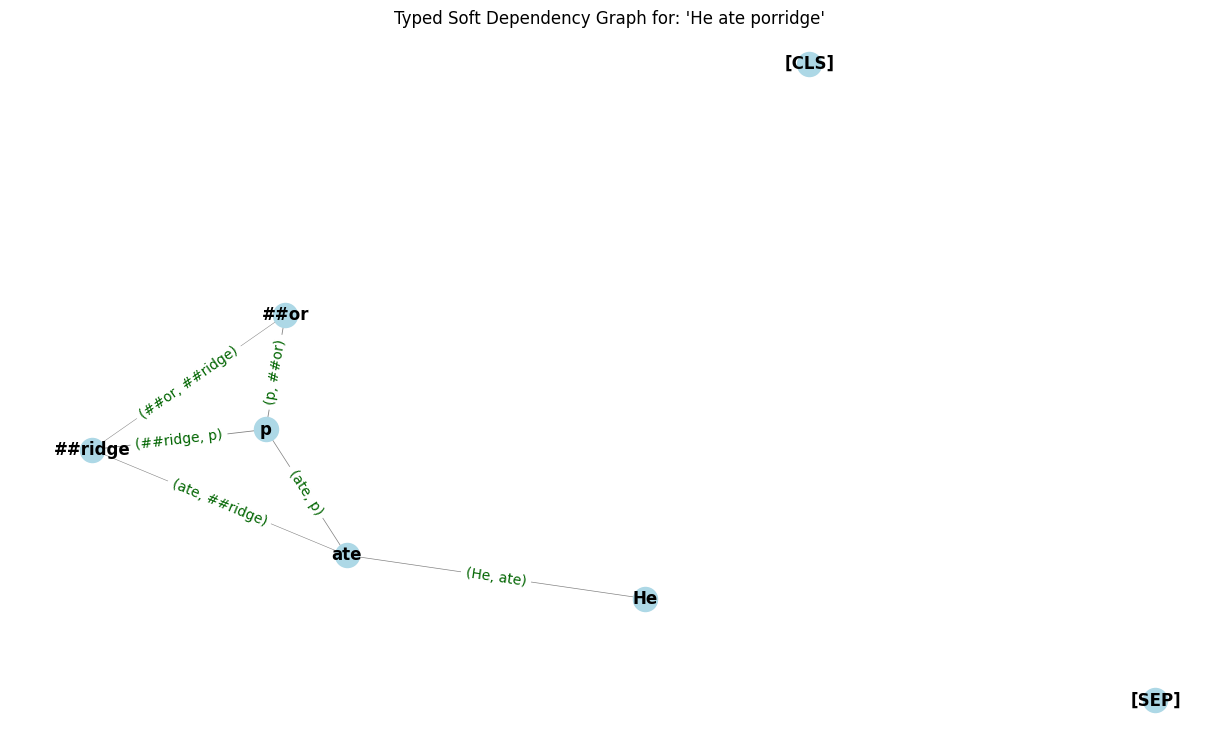

In [13]:
visualize_soft_dependencies("He ate porridge")